In [1]:
import copy
import torch
import time
import os

import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchviz import make_dot
from def_model import EarthquakeCNN

import functions

In [2]:
class EarthquakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
datadir = './data_train/pth'

train_data_path = os.path.join(datadir, "train.pth")
train_data = torch.load(train_data_path)
Xtrain = train_data['Xtrain']
Ytrain = train_data['Ytrain']

test_data_path = os.path.join(datadir, "test.pth")
test_data = torch.load(test_data_path)
Xtest = test_data['Xtest']
Ytest = test_data['Ytest']

In [4]:
Xtrain, Ytrain = functions.remove_small_amplitude(Xtrain, Ytrain) 
Xtrain, Ytrain = functions.remove_large_amplitude(Xtrain, Ytrain)
log10_amplitude = np.log10(np.max(np.abs(Xtrain), axis = (1, 2, 3)))
Xtrain = functions.normalize(Xtrain)
Xtrain = functions.quantize(Xtrain)
Xtrain = Xtrain.astype(np.float32)
Xtrain = functions.normalize(Xtrain)

Xtest, Ytest = functions.remove_small_amplitude(Xtest, Ytest) 
Xtest, Ytest = functions.remove_large_amplitude(Xtest, Ytest)
log10_amplitude = np.log10(np.max(np.abs(Xtest), axis = (1, 2, 3)))
Xtest = functions.normalize(Xtest)
Xtest = functions.quantize(Xtest)
Xtest = Xtest.astype(np.float32)
Xtest = functions.normalize(Xtest)

In [5]:
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).float()
Xtest = torch.from_numpy(Xtest).float()
Ytest = torch.from_numpy(Ytest).float()

Xtrain = Xtrain.permute(0, 3, 1, 2)
Xtest = Xtest.permute(0, 3, 1, 2)

In [6]:
# split the data into training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 42)

# create datasets
train_dataset = EarthquakeDataset(X_train, Y_train)
val_dataset = EarthquakeDataset(X_val, Y_val)

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 256, shuffle = True)

# put dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# similarly, create a dictionary for dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [7]:
class MyModel:
    def __init__(self, model, epoch_arr, train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr, lr_arr, cm, best_acc):
        self.model = model
        self.epoch_arr = epoch_arr
        self.train_loss_arr = train_loss_arr
        self.val_loss_arr = val_loss_arr
        self.train_acc_arr = train_acc_arr
        self.val_acc_arr = val_acc_arr
        self.lr_arr = lr_arr
        self.cm = cm
        self.best_acc = best_acc

In [8]:
def plot_loss_with_MyModel(MyModel_here, plot_title = "Default"):
    epoch_arr_here = MyModel_here.epoch_arr
    train_loss_arr_here = MyModel_here.train_loss_arr
    val_loss_arr_here = MyModel_here.val_loss_arr
    train_acc_arr_here = MyModel_here.train_acc_arr
    val_acc_arr_here = MyModel_here.val_acc_arr
    lr_arr_here = MyModel_here.lr_arr

    fig_loss_func, axes_loss_func = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 6))
    fig_loss_func.suptitle(plot_title)

    axes_loss_func[0].plot(epoch_arr_here, train_loss_arr_here, label = 'Training Loss')
    axes_loss_func[0].plot(epoch_arr_here, val_loss_arr_here, label = 'Validation Loss')
    axes_loss_func[0].set_title('Loss')
    axes_loss_func[0].set_xlabel('Epoch')
    axes_loss_func[0].set_ylabel('Loss')
    axes_loss_func[0].legend()
    axes_loss_func[1].plot(epoch_arr_here, train_acc_arr_here, label = 'Training Accuracy')
    axes_loss_func[1].plot(epoch_arr_here, val_acc_arr_here, label = 'Validation Accuracy')
    axes_loss_func[1].set_title('Accuracy')
    axes_loss_func[1].set_xlabel('Epoch')
    axes_loss_func[1].set_ylabel('Accurracy')
    axes_loss_func[1].legend()
    axes_loss_func[2].plot(epoch_arr_here, lr_arr_here, label = 'Learning Rate')
    axes_loss_func[2].set_title('Learning Rate')
    axes_loss_func[2].set_xlabel('Epoch')
    axes_loss_func[2].set_ylabel('Accuracy')
    axes_loss_func[2].legend()
    fig_loss_func.tight_layout()
    plt.savefig('./Result_Training/Accurracy.pdf')

In [9]:
def plot_cm_with_MyModel(MyModel_here, plot_title = "Default"):

    cm_here = MyModel_here.cm
    cm_here = cm_here.astype('float') / cm_here.sum(axis = 1)[:, np.newaxis]

    labels = ['P-wave', 'S-wave', 'Noise']
    cm_here_df = pd.DataFrame(cm_here, index = labels, columns = labels)
    cm_here = cm_here_df

    fig_cm_func, axes_cm_func = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))
    acc_here = MyModel_here.best_acc.detach().cpu().numpy() * 100
    acc_here = round(acc_here, 2)
    fig_cm_func.suptitle(plot_title + ' Confusion Matrix, Accuracy = ' + str(acc_here) + '%')

    sns.heatmap(cm_here, annot = True, cmap = 'Blues', ax = axes_cm_func)
    axes_cm_func.set_title('Train Confusion Matrix')
    axes_cm_func.set_xlabel('Predicted Labels')
    axes_cm_func.set_ylabel('Actual Labels')
    fig_cm_func.tight_layout()

    plt.savefig('./Result_Training/Confusion_Matrix.pdf')

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_arr = np.array([])
    lr_arr = np.array([])
    train_loss_arr = np.array([])
    train_acc_arr = np.array([])

    val_loss_arr = np.array([])
    val_acc_arr = np.array([])

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # These lists will hold all labels and predictions for this epoch
            # all_labels = []
            # all_preds = []

            all_labels = np.array([])
            all_preds = np.array([])

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs
                labels = labels

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, labels = torch.max(labels.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Add current labels and predictions to the lists
                # all_labels.extend(labels.tolist())
                # all_preds.extend(preds.tolist())

                all_labels = np.append(all_labels, labels.tolist())
                all_preds = np.append(all_preds, preds.tolist())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # After each epoch, compute and print the confusion matrix
            if phase == 'val':
                print("Confusion Matrix:")
                cm_here = confusion_matrix(all_labels, all_preds)
                print(cm_here)

            # save the loss and accurracy
            if phase == 'train':
                train_loss_arr = np.append(train_loss_arr, epoch_loss)
                train_acc_arr = np.append(train_acc_arr, epoch_acc.detach().cpu())
                lr_arr = np.append(lr_arr, optimizer.param_groups[0]['lr'])
                epoch_arr = np.append(epoch_arr, epoch)
            elif phase == 'val':
                val_loss_arr = np.append(val_loss_arr, epoch_loss)
                val_acc_arr = np.append(val_acc_arr, epoch_acc.detach().cpu())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    model_class = MyModel(model = model, 
                          epoch_arr = epoch_arr, 
                          train_loss_arr = train_loss_arr, 
                          val_loss_arr = val_loss_arr, 
                          train_acc_arr = train_acc_arr, 
                          val_acc_arr = val_acc_arr, 
                          lr_arr = lr_arr, 
                          cm = cm_here, 
                          best_acc = best_acc)

    return model_class

In [11]:
model = EarthquakeCNN()
criterion = nn.CrossEntropyLoss()

# 使用Adam優化器，並且設定學習率為0.001
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# 每7個epoch，學習率減半
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.5)


In [12]:
trained_MyModel = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs = 50)

Epoch 0/49
----------
train Loss: 0.3449 Acc: 0.8513
val Loss: 0.2375 Acc: 0.9051
Confusion Matrix:
[[2851  561   21]
 [ 431 2967  118]
 [  13  250 7475]]
Epoch 1/49
----------
train Loss: 0.2258 Acc: 0.9049
val Loss: 0.2013 Acc: 0.9176
Confusion Matrix:
[[2811  591   31]
 [ 310 3013  193]
 [   5   80 7653]]
Epoch 2/49
----------
train Loss: 0.2052 Acc: 0.9129
val Loss: 0.2062 Acc: 0.9128
Confusion Matrix:
[[2626  767   40]
 [ 169 3076  271]
 [   2   32 7704]]
Epoch 3/49
----------
train Loss: 0.1924 Acc: 0.9179
val Loss: 0.1841 Acc: 0.9210
Confusion Matrix:
[[2667  738   28]
 [ 151 3171  194]
 [   3   46 7689]]
Epoch 4/49
----------
train Loss: 0.1846 Acc: 0.9207
val Loss: 0.1788 Acc: 0.9216
Confusion Matrix:
[[2646  769   18]
 [ 144 3223  149]
 [   2   69 7667]]
Epoch 5/49
----------
train Loss: 0.1749 Acc: 0.9248
val Loss: 0.1755 Acc: 0.9208
Confusion Matrix:
[[2599  811   23]
 [ 110 3246  160]
 [   2   57 7679]]
Epoch 6/49
----------
train Loss: 0.1714 Acc: 0.9268
val Loss: 0.1600 

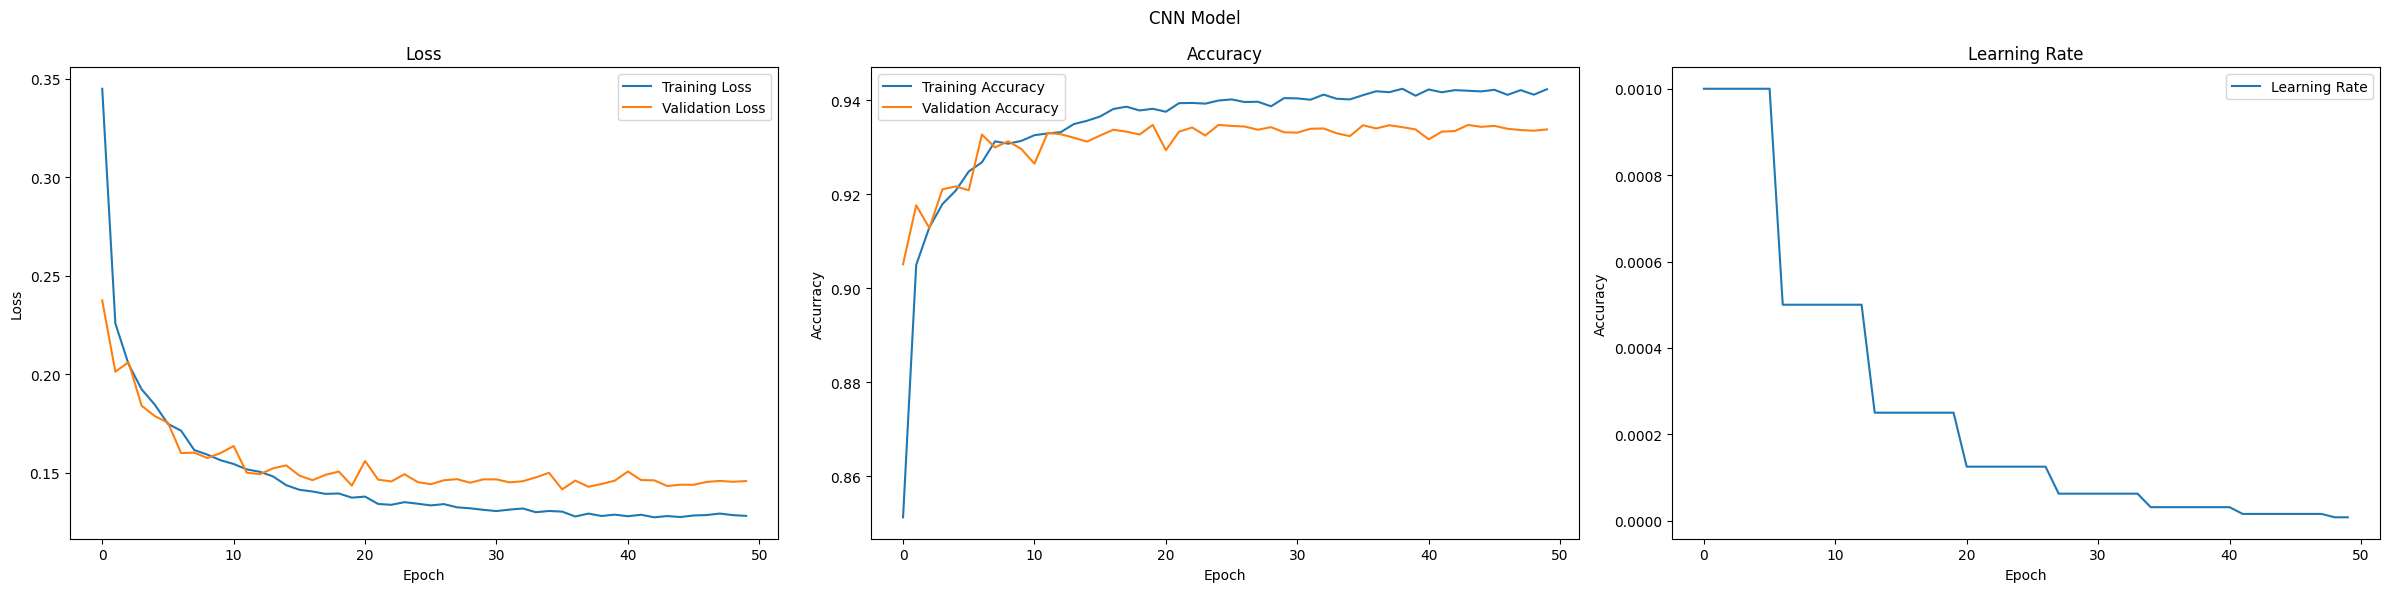

In [13]:
plot_loss_with_MyModel(trained_MyModel, plot_title = "CNN Model")

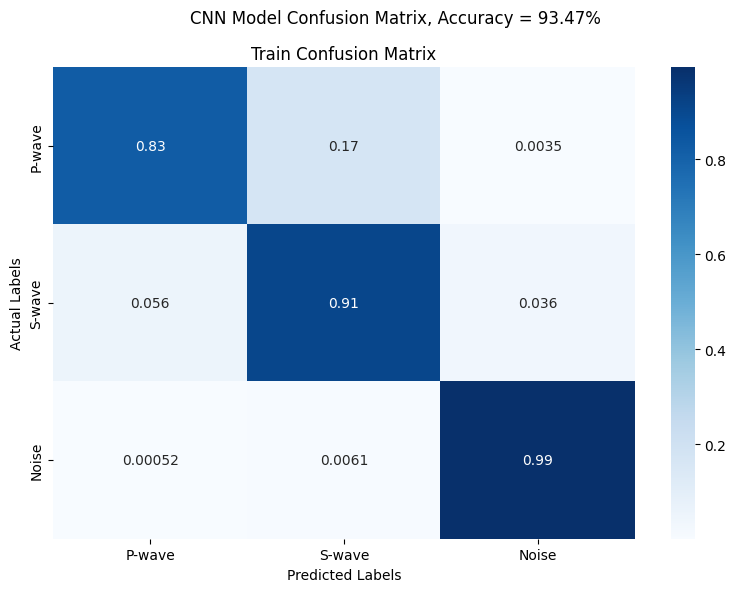

In [14]:
plot_cm_with_MyModel(MyModel_here = trained_MyModel, plot_title = "CNN Model")

In [15]:
torch.save(trained_MyModel.model, './model/EarthquakeCNN.pth')
model = torch.load('./model/EarthquakeCNN.pth')

In [16]:
input_tensor = torch.randn(1, 1, 80, 3)
output = model(input_tensor)
dot = make_dot(output, params = dict(model.named_parameters()), show_attrs = False)
dot.render("./model_structure/EarthquakeCNN_Model", format = "pdf")
os.remove("./model_structure/EarthquakeCNN_Model")